# Tutorial

# Bayesian Linear Regression Model
--------------------------------

このセクションでは、BUGS 0.5のマニュアルから引用した、ベイズによる単純線形回帰を用いてこのパッケージの特徴を説明する。この例は観測値${x} = (1, 2, 3, 4, 5)^\top$と${y} = (1, 3, 3, 3, 5)^\top$との間の回帰関係を記述する。これは次のように表現できる。

$ \bf{y}  \sim Normal (\bf{\mu}, \sigma^2 \bf{I})$

$\bf{\mu} = \bf{X} \bf{\beta} $

ここで事前分布は、

$ 
\bf{\beta} \sim \it{Normal}(
\bf{\mu}_\pi =
\begin{bmatrix}
0 \\
0 
\end{bmatrix},
\bf{\sigma}_\pi =
\begin{bmatrix}
1000 & 0 \\
0 & 1000 
\end{bmatrix} )
$


$\sigma^2 \sim InverseGamma(\alpha_\pi = 0.001, \beta_\pi = 0.001)$

where $ \bf{\beta} = (\beta_0, \beta_1)^\T $, $\bf{X}$ は第1列に切片ベクトルを持ち、第2列以降に$x$ベクトルをもつ。$\beta_1$ と$\sigma^2$は、主要な関心は事後分布に基づいて各パラメーターの推定を行うことである。事後分布に基づいたパラメータである。この例における計算的な問題は、推論は直接的に結合事後分布から得られないということである。なぜなら　 because of its nonstandard form, derived below up to a constant of proportionality.　しかも、βとσの具体的な推定を行うためにはさらにその周辺確率密度関数を求めなくてはならない。

$ 
p(\bf{\beta}, \sigma^2 | \bf{y}) \propto
p(\bf{y} | \bf{\beta}, \sigma^2) p(\bf{\beta}) p(\sigma^2) 
$

$
\propto \left(\sigma^2\right)^{-n/2} \exp\left\{-\frac{1}{2 \sigma^2} (\bf{y} - \bf{X} \bf{\beta})^\top (\bf{y} - \bf{X} \bf{\beta}) \right\} 
$

$
\quad \times \exp\left\{-\frac{1}{2} (\bf{\beta} - \bf{\mu}_\pi)^\top \bf{\Sigma}_\pi^{-1} (\bf{\beta} - \bf{\mu}_\pi) \right\}
\left(\sigma^2\right)^{-\alpha_\pi - 1} \exp\left\{-\beta_\pi / \sigma^2\right\}
$

代替的な手法としては、MCMCを用いて事後分布からパラメーターの値についての近似的な推論を行うことである。

# Model Specification
-------------------

## Nodes

Mamba パッケージの中では、ベイジアンモデルの推定の際に現れる用語は"nodes"として参照される。Nodesは次の3つのタイプのどれかに分類される。

### Stochastic nodes
尤度や事前分布推定をされた値である。この回帰の例では、$\bf{y}$, $\bf{\beta}$、と $\sigma^2$ がstochastic nodesである。
### Logical nodes
are terms, like :math:`\bm{\mu}`, that are deterministic functions of other nodes.
### Input nodes
are any remaining model terms (:math:`\bm{X}`) and are considered to be fixed quantities in the analysis.

Note that the :math:`\bm{y}` node has both a distributional specification and is a fixed quantity.  It is designated a stochastic node in `Mamba` because of its distributional specification.  This allows for the possibility of model terms with distributional specifications that are a mix of observed and unobserved elements, as in the case of missing values in response vectors.

Model implementation begins by instantiating stochastic and logical nodes using the `Mamba`--supplied constructors ``Stochastic`` and ``Logical``.  Stochastic and logical nodes for a model are defined with a call to the ``Model`` constructor.  The model constructor formally defines and assigns names to the nodes.  User-specified names are given on the left-hand sides of the arguments to which ``Logical`` and ``Stochastic`` nodes are passed.

In [1]:
using Mamba

## Model Specification

model = Model(

  y = Stochastic(1,
    (mu, s2) ->  MvNormal(mu, sqrt(s2)),
    false
  ),

  mu = Logical(1,
    (xmat, beta) -> xmat * beta,
    false
  ),

  beta = Stochastic(1,
    () -> MvNormal(2, sqrt(1000))
  ),

  s2 = Stochastic(
    () -> InverseGamma(0.001, 0.001)
  )

)

Object of type "Mamba.Model"
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
mu:
An unmonitored node of type "0-element Mamba.ArrayLogical{1}"
Float64[]


A single integer value for the first Stochastic constructor argument indicates that the node is an array of the specified dimension. Absence of an integer value implies a scalar node. The next argument is a function that may contain any valid julia code. Functions should be defined to take, as their arguments, the inputs upon which their nodes depend and, for stochastic nodes, return distribution objects or arrays of objects compatible with the Distributions package [2]. Such objects represent the nodes’ distributional specifications. An optional boolean argument after the function can be specified to indicate whether values of the node should be monitored (saved) during MCMC simulations (default: true).

Stochastic functions must return a single distribution object that can accommodate the dimensionality of the node, or return an array of (univariate or multivariate) distribution objects of the same dimension as the node. Examples of alternative, but equivalent, prior distributional specifications for the beta node are shown below.



In [2]:
# Case 1: Multivariate Normal with independence covariance matrix
beta = Stochastic(1,
  () -> MvNormal(2, sqrt(1000))
)

# Case 2: One common univariate Normal
beta = Stochastic(1,
  () -> Normal(0, sqrt(1000))
)

# Case 3: Array of univariate Normals
beta = Stochastic(1,
  () -> UnivariateDistribution[Normal(0, sqrt(1000)), Normal(0, sqrt(1000))]
)

# Case 4: Array of univariate Normals
beta = Stochastic(1,
  () -> UnivariateDistribution[Normal(0, sqrt(1000)) for i in 1:2]
)

0-element Mamba.ArrayStochastic{1}

Case 1 is one of the multivariate normal distributions available in the Distributions package, and the specification used in the example model implementation. In Case 2, a single univariate normal distribution is specified to imply independent priors of the same type for all elements of beta. Cases 3 and 4 explicitly specify a univariate prior for each element of beta and allow for the possibility of differences among the priors. Both return arrays of Distribution objects, with the last case automating the specification of array elements.

In summary, y and beta are stochastic vectors, s2 is a stochastic scalar, and mu is a logical vector. We note that the model could have been implemented without mu. It is included here primarily to illustrate use of a logical node. Finally, note that nodes y and mu are not being monitored.


# Sampling Schemes
--------------------------------
The package provides a flexible system for the specification of schemes to sample stochastic nodes. Arbitrary blocking of nodes and designation of block-specific samplers is supported. Furthermore, block-updating of nodes can be performed with samplers provided, defined by the user, or available from other packages. Schemes are specified as vectors of Sampler objects. Constructors are provided for several popular sampling algorithms, including adaptive Metropolis, No-U-Turn (NUTS), and slice sampling. Example schemes are shown below. In the first one, NUTS is used for the sampling of beta and slice for s2. The two nodes are block together in the second scheme and sampled jointly with NUTS.

In [4]:
## Hybrid No-U-Turn and Slice Sampling Scheme
scheme1 = [NUTS(:beta),
           Slice(:s2, 3.0)]

## No-U-Turn Sampling Scheme
scheme2 = [NUTS([:beta, :s2])]

1-element Array{Mamba.Sampler{Mamba.NUTSTune},1}:
 An object of type "Mamba.Sampler{Mamba.NUTSTune}"
Sampling Block Nodes:
[:beta,:s2]

AST(:($(Expr(:lambda, Any[:(model::Model),:(block::Integer)], Any[Any[Any[:model,:Any,18],Any[:block,:Any,18],Any[:f,:Any,18]],Any[],0,Any[]], :(begin 
        model = (top(typeassert))(model,Mamba.Model)
        block = (top(typeassert))(block,Mamba.Integer)
        f = (anonymous function)
        return f(model,block)
    end)))))


Additionally, users are free to create their own samplers with the generic Sampler constructor. This is particularly useful in settings were full conditional distributions are of standard forms for some nodes and can be sampled from directly. Such is the case for the full conditional of \bm{\beta} which can be written as

p(\bm{\beta} | \sigma^2, \bm{y}) &\propto p(\bm{y} | \bm{\beta}, \sigma^2) p(\bm{\beta}) \\
&\propto \exp\left\{-\frac{1}{2} (\bm{\beta} - \bm{\mu})^\top \bm{\Sigma}^{-1} (\bm{\beta} - \bm{\mu})\right\},

where \bm{\Sigma} = \left(\frac{1}{\sigma^2} \bm{X}^\top \bm{X} + \bm{\Sigma}_\pi^{-1}\right)^{-1} and \bm{\mu} = \bm{\Sigma} \left(\frac{1}{\sigma^2} \bm{X}^\top \bm{y} + \bm{\Sigma}_\pi^{-1} \bm{\mu}_\pi\right), and is recognizable as multivariate normal. Likewise,

p(\sigma^2 | \bm{\beta}, \mathbf{y}) &\propto p(\bm{y} | \bm{\beta}, \sigma^2) p(\sigma^2) \\
&\propto \left(\sigma^2\right)^{-(n/2 + \alpha_\pi) - 1} \exp\left\{-\frac{1}{\sigma^2} \left(\frac{1}{2} (\bm{y} - \bm{X} \bm{\beta})^\top (\bm{y} - \bm{X} \bm{\beta}) + \beta_\pi \right) \right\},

whose form is inverse gamma with n / 2 + \alpha_\pi shape and (\bm{y} - \bm{X} \bm{\beta})^\top (\bm{y} - \bm{X} \bm{\beta}) / 2 + \beta_\pi scale parameters. A user-defined sampling scheme to generate draws from these full conditionals is constructed below. Another example is given in the Pollution example for the sampling of multiple nodes.

In [5]:
## User-Defined Samplers

Gibbs_beta = Sampler([:beta],
  (beta, s2, xmat, y) ->
    begin
      beta_mean = mean(beta.distr)
      beta_invcov = invcov(beta.distr)
      Sigma = inv(xmat' * xmat / s2 + beta_invcov)
      mu = Sigma * (xmat' * y / s2 + beta_invcov * beta_mean)
      rand(MvNormal(mu, Sigma))
    end
)

Gibbs_s2 = Sampler([:s2],
  (mu, s2, y) ->
    begin
      a = length(y) / 2.0 + shape(s2.distr)
      b = sumabs2(y - mu) / 2.0 + scale(s2.distr)
      rand(InverseGamma(a, b))
    end
)

## User-Defined Sampling Scheme
scheme3 = [Gibbs_beta, Gibbs_s2]

2-element Array{Mamba.Sampler{Dict{Any,Any}},1}:
 An object of type "Mamba.Sampler{Dict{Any,Any}}"
Sampling Block Nodes:
[:beta]

AST(:($(Expr(:lambda, Any[:(model::Model),:(block::Integer)], Any[Any[Any[:model,:Any,18],Any[:block,:Any,18],Any[:f,:Any,18]],Any[],0,Any[]], :(begin 
        model = (top(typeassert))(model,Mamba.Model)
        block = (top(typeassert))(block,Mamba.Integer)
        f = (anonymous function)
        return f((Mamba.getindex)(model,:beta),(Mamba.getindex)(model,:s2),(Mamba.getindex)(model,:xmat),(Mamba.getindex)(model,:y))
    end)))))

 An object of type "Mamba.Sampler{Dict{Any,Any}}"
Sampling Block Nodes:
[:s2]

AST(:($(Expr(:lambda, Any[:(model::Model),:(block::Integer)], Any[Any[Any[:model,:Any,18],Any[:block,:Any,18],Any[:f,:Any,18]],Any[],0,Any[]], :(begin 
        model = (top(typeassert))(model,Mamba.Model)
        block = (top(typeassert))(block,Mamba.Integer)
        f = (anonymous function)
        return f((Mamba.getindex)(model,:mu),(Mamba.getind

In these samplers, the respective MvNormal(2, sqrt(1000)) and InverseGamma(0.001, 0.001) priors on stochastic nodes beta and s2 are accessed directly through the distr fields. Features of the Distributions objects returned by beta.distr and s2.distr can, in turn, be extracted with method functions defined in that package or through their own fields. For instance, mean(beta.distr) and invcov(beta.distr) apply method functions to extract the mean vector and inverse-covariance matrix of the beta prior. Whereas, shape(s2.distr) and scale(s2.distr) extract the shape and scale parameters from fields of the inverse-gamma prior. Distributions method functions can be found in that package’s documentation; whereas, fields are found in the source code.

When possible to do so, direct sampling from full conditions is often preferred in practice because it tends to be more efficient than general-purpose algorithms. Schemes that mix the two approaches can be used if full conditionals are available for some model parameters but not for others. Once a sampling scheme is formulated in Mamba, it can be assigned to an existing model with a call to the setsamplers! function.

In [6]:
## Sampling Scheme Assignment
setsamplers!(model, scheme1)

Object of type "Mamba.Model"
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
mu:
An unmonitored node of type "0-element Mamba.ArrayLogical{1}"
Float64[]


Alternatively, a predefined scheme can be passed in to the Model constructor at the time of model implementation as the value to its samplers argument.

# Directed Acyclic Graphs
---------------------
One of the internal structures created by Model is a graph representation of the model nodes and their associations. Graphs are managed internally with the Graphs package [96]. Like OpenBUGS, JAGS, and other BUGS clones, Mamba fits models whose nodes form a directed acyclic graph (DAG). A DAG is a graph in which nodes are connected by directed edges and no node has a path that loops back to itself. With respect to statistical models, directed edges point from parent nodes to the child nodes that depend on them. Thus, a child node is independent of all others, given its parents.

The DAG representation of a Model can be printed out at the command-line or saved to an external file in a format that can be displayed with the Graphviz software.

In [7]:
## Graph Representation of Nodes

draw(model)

digraph MambaModel {
	"y" [shape="ellipse", fillcolor="gray85", style="filled"];
	"mu" [shape="diamond", fillcolor="gray85", style="filled"];
		"mu" -> "y";
	"s2" [shape="ellipse"];
		"s2" -> "y";
	"beta" [shape="ellipse"];
		"beta" -> "mu";
	"xmat" [shape="box", fillcolor="gray85", style="filled"];
		"xmat" -> "mu";
}


In [9]:
draw(model, filename="lineDAG.dot")

In [10]:
draw(model)

digraph MambaModel {
	"y" [shape="ellipse", fillcolor="gray85", style="filled"];
	"mu" [shape="diamond", fillcolor="gray85", style="filled"];
		"mu" -> "y";
	"s2" [shape="ellipse"];
		"s2" -> "y";
	"beta" [shape="ellipse"];
		"beta" -> "mu";
	"xmat" [shape="box", fillcolor="gray85", style="filled"];
		"xmat" -> "mu";
}


In [24]:
using GraphViz

display(Graph(graph2dot(model)))

  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:33
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:33
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:82
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:82
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:89
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:89
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:96
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:96
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:103
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:103
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:109
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:109
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:138
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:138
  likely near /Users/NIGG/.julia/v0.4/GraphViz/src/GraphViz.jl:138
  l

Stochastic, logical, and input nodes are represented by ellipses, diamonds, and rectangles, respectively. Gray-colored nodes are ones designated as unmonitored in MCMC simulations. The DAG not only allows the user to visually check that the model specification is the intended one, but is also used internally to check that nodal relationships are acyclic.

# MCMC Simulation
----------------
## Data
For the example, observations (\bm{x}, \bm{y}) are stored in a julia dictionary defined in the code block below. Included are predictor and response vectors :x and :y as well as a design matrix :xmat corresponding to the model matrix \bm{X}.

In [11]:
## Data
line = Dict{Symbol, Any}(
  :x => [1, 2, 3, 4, 5],
  :y => [1, 3, 3, 3, 5]
)
line[:xmat] = [ones(5) line[:x]]

5x2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0

In [12]:
line

Dict{Symbol,Any} with 3 entries:
  :y    => [1,3,3,3,5]
  :xmat => 5x2 Array{Float64,2}:…
  :x    => [1,2,3,4,5]

In [13]:
line[:xmat]

5x2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0

## Initial Values
A julia vector of dictionaries containing initial values for all stochastic nodes must be created. The dictionary keys should match the node names, and their values should be vectors whose elements are the same type of structures as the nodes. Three sets of initial values for the regression example are created in with the following code.

In [14]:
## Initial Values
inits = [
  Dict{Symbol, Any}(
    :y => line[:y],
    :beta => rand(Normal(0, 1), 2),
    :s2 => rand(Gamma(1, 1))
  )
for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict{Symbol,Any}(:y=>[1,3,3,3,5],:s2=>0.058258347204980215,:beta=>[0.9469661804320222,0.8031259866984112])
 Dict{Symbol,Any}(:y=>[1,3,3,3,5],:s2=>1.127540450126954,:beta=>[-0.8161166970028252,1.4336941229442106])  
 Dict{Symbol,Any}(:y=>[1,3,3,3,5],:s2=>2.6363760952358524,:beta=>[-1.0123138803474905,2.274138147263164])  

In [25]:
Dict(
    :y => line[:y],
    :beta => rand(Normal(0, 1), 2),
    :s2 => rand(Gamma(1, 1))
  )

Dict{Symbol,Any} with 3 entries:
  :y    => [1,3,3,3,5]
  :s2   => 1.806998491273362
  :beta => [0.5906899580963741,1.7453077987260508]

In [15]:
inits

3-element Array{Dict{Symbol,Any},1}:
 Dict{Symbol,Any}(:y=>[1,3,3,3,5],:s2=>0.058258347204980215,:beta=>[0.9469661804320222,0.8031259866984112])
 Dict{Symbol,Any}(:y=>[1,3,3,3,5],:s2=>1.127540450126954,:beta=>[-0.8161166970028252,1.4336941229442106])  
 Dict{Symbol,Any}(:y=>[1,3,3,3,5],:s2=>2.6363760952358524,:beta=>[-1.0123138803474905,2.274138147263164])  

Initial values for y are those in the observed response vector. Likewise, the node is not updated in the sampling schemes defined earlier and thus retains its initial values throughout MCMC simulations. Initial values are generated for beta from a normal distribution and for s2 from a gamma distribution.

## MCMC Engine
MCMC simulation of draws from the posterior distribution of a declared set of model nodes and sampling scheme is performed with the mcmc() function. As shown below, the first three arguments are a Model object, a dictionary of values for input nodes, and a dictionary vector of initial values. The number of draws to generate in each simulation run is given as the fourth argument. The remaining arguments are named such that burnin is the number of initial values to discard to allow for convergence; thin defines the interval between draws to be retained in the output; and chains specifies the number of times to run the simulator. Results are retuned as Chains objects on which methods for posterior inference are defined.

In [16]:
## MCMC Simulations

setsamplers!(model, scheme1)
sim1 = mcmc(model, line, inits, 10000, burnin=250, thin=2, chains=3)

setsamplers!(model, scheme2)
sim2 = mcmc(model, line, inits, 10000, burnin=250, thin=2, chains=3)

setsamplers!(model, scheme3)
sim3 = mcmc(model, line, inits, 10000, burnin=250, thin=2, chains=3)

MCMC Simulation of 10000 Iterations x 3 Chains...

Chain 1:   0% [0:39:05 of 0:39:07 remaining]
Chain 1:  10% [0:00:31 of 0:00:35 remaining]
Chain 1:  20% [0:00:19 of 0:00:23 remaining]
Chain 1:  30% [0:00:13 of 0:00:18 remaining]
Chain 1:  40% [0:00:09 of 0:00:15 remaining]
Chain 1:  50% [0:00:07 of 0:00:14 remaining]
Chain 1:  60% [0:00:05 of 0:00:13 remaining]
Chain 1:  70% [0:00:04 of 0:00:12 remaining]
Chain 1:  80% [0:00:02 of 0:00:12 remaining]
Chain 1:  90% [0:00:01 of 0:00:11 remaining]
Chain 1: 100% [0:00:00 of 0:00:11 remaining]

Chain 2:   0% [0:00:07 of 0:00:07 remaining]
Chain 2:  10% [0:00:08 of 0:00:08 remaining]
Chain 2:  20% [0:00:07 of 0:00:09 remaining]
Chain 2:  30% [0:00:06 of 0:00:09 remaining]
Chain 2:  40% [0:00:05 of 0:00:08 remaining]
Chain 2:  50% [0:00:04 of 0:00:08 remaining]
Chain 2:  60% [0:00:03 of 0:00:08 remaining]
Chain 2:  70% [0:00:02 of 0:00:08 remaining]
Chain 2:  80% [0:00:02 of 0:00:09 remaining]
Chain 2:  90% [0:00:01 of 0:00:09 remaining]
Cha

Object of type "Mamba.ModelChains"

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

4875x3x3 Array{Float64,3}:
[:, :, 1] =
 -0.353432   1.22336   0.626502
  0.834745   0.732582  0.47187 
 -0.255598   1.21912   0.85898 
 -0.1448     1.02101   0.855564
  0.980004   0.260487  3.61662 
  1.37       0.631485  0.776893
  0.539058   0.568659  1.24218 
  0.465335   0.887165  0.65956 
  1.37034    0.631577  0.293293
  2.17015    0.618135  1.87708 
  0.420805   0.896262  0.366359
  1.18658    0.686379  0.610036
 -1.21077    1.27881   4.41761 
  ⋮                            
  1.41881    0.712045  0.797784
  0.402535   0.906317  0.611475
  0.472403   0.776721  0.364308
 -1.07915    1.06884   0.739251
  1.75577    0.33621   0.626152
 -0.0306141  0.912442  0.289914
  0.916934   0.579964  1.77511 
  0.0965449  0.869485  0.163993
 -2.86106    1.68835   5.74965 
 -0.415854   1.33493   2.16969 
 -1.7658     1.70172   3.62366 
  0.311763   0.823671  0.505343

[:, :,

Chain 3: 100% [0:00:00 of 0:00:01 remaining]



In [17]:
model, line, inits

(Object of type "Mamba.Model"
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
mu:
An unmonitored node of type "0-element Mamba.ArrayLogical{1}"
Float64[]
,Dict{Symbol,Any}(:y=>[1,3,3,3,5],:xmat=>5x2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0,:x=>[1,2,3,4,5]),[Dict{Symbol,Any}(:y=>[1,3,3,3,5],:s2=>0.058258347204980215,:beta=>[0.9469661804320222,0.8031259866984112]),Dict{Symbol,Any}(:y=>[1,3,3,3,5],:s2=>1.127540450126954,:beta=>[-0.8161166970028252,1.4336941229442106]),Dict{Symbol,Any}(

In [18]:
setsamplers!(model, scheme1)

Object of type "Mamba.Model"
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
mu:
An unmonitored node of type "0-element Mamba.ArrayLogical{1}"
Float64[]


In [21]:
setsamplers!

setsamplers! (generic function with 1 method)

## Parallel Computing
The simulation of multiple chains will be executed in parallel automatically if julia is running in multiprocessor mode on a multiprocessor system. Multiprocessor mode can be started with the command line argument julia -p n, where n is the number of available processors. See the julia documentation on parallel computing for details.

# Posterior Inference
## Convergence Diagnostics
Checks of MCMC output should be performed to assess convergence of simulated draws to the posterior distribution. Checks can be performed with a variety of methods. The diagnostic of Gelman, Rubin, and Brooks [32][11] is one method for assessing convergence of posterior mean estimates. Values of the diagnostic’s potential scale reduction factor (PSRF) that are close to one suggest convergence. As a rule-of-thumb, convergence is rejected if the 97.5 percentile of a PSRF is greater than 1.2.

In [23]:
gelmandiag(sim1, mpsrf=true, transform=true) |> showall

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

Gelman, Rubin, and Brooks Diagnostic:
              PSRF 97.5%
     beta[1] 1.003 1.004
     beta[2] 1.003 1.003
          s2 1.004 1.006
Multivariate 1.001   NaN



The diagnostic of Geweke [36] tests for non-convergence of posterior mean estimates. It provides chain-specific test p-values. Convergence is rejected for significant p-values, like those obtained for s2.

In [30]:
gewekediag(sim1) |> showall

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2
Samples per chain = 4875

Geweke Diagnostic:
First Window Fraction = 0.1
Second Window Fraction = 0.5

        Z-score p-value
beta[1]  -1.591  0.1117
beta[2]   1.768  0.0770
     s2  -0.403  0.6869

        Z-score p-value
beta[1]  -0.264  0.7916
beta[2]   0.206  0.8367
     s2  -0.385  0.7000



The diagnostic of Heidelberger and Welch [45] tests for non-convergence (non-stationarity) and whether ratios of estimation interval halfwidths to means are within a target ratio. Stationarity is rejected (0) for significant test p-values. Halfwidth tests are rejected (0) if observed ratios are greater than the target, as is the case for s2 and beta[1].

In [31]:
heideldiag(sim1) |> showall

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2
Samples per chain = 4875

Heidelberger and Welch Diagnostic:
Target Halfwidth Ratio = 0.1
Alpha = 0.05

        Burn-in Stationarity p-value    Mean    Halfwidth  Test
beta[1]     738            1  0.0958 0.6273351 0.058129601    1
beta[2]     738            1  0.0906 0.7909868 0.016339055    1
     s2     251            1  0.2363 1.1007973 0.145055991    0

        Burn-in Stationarity p-value    Mean    Halfwidth  Test
beta[1]     251            1  0.9853 0.6154344 0.063751489    0
beta[2]     251            1  0.8866 0.7947088 0.017502193    1
     s2     251            1  0.8428 1.3175961 0.543178726    0



The diagnostic of Raftery and Lewis [72][73] is used to determine the number of iterations required to estimate a specified quantile within a desired degree of accuracy. For example, below are required total numbers of iterations, numbers to discard as burn-in sequences, and thinning intervals for estimating 0.025 quantiles so that their estimated cumulative probabilities are within 0.025±0.005 with probability 0.95.

In [32]:
rafterydiag(sim1) |> showall

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2
Samples per chain = 4875

Raftery and Lewis Diagnostic:
Quantile (q) = 0.025
Accuracy (r) = 0.005
Probability (s) = 0.95

        Thinning Burn-in    Total   Nmin Dependence Factor
beta[1]        2     267 1.8257×10⁴ 3746         4.8737320
beta[2]        4     267 2.0211×10⁴ 3746         5.3953550
     s2        2     257 8.6890×10³ 3746         2.3195408

        Thinning Burn-in    Total   Nmin Dependence Factor
beta[1]        2     271 2.1549×10⁴ 3746         5.7525360
beta[2]        6     275 3.6209×10⁴ 3746         9.6660438
     s2        2     257 8.6890×10³ 3746         2.3195408



More information on the diagnostic functions can be found in the Convergence Diagnostics section.

## Posterior Summaries
Once convergence has been assessed, sample statistics may be computed on the MCMC output to estimate features of the posterior distribution. The StatsBase package [51] is utilized in the calculation of many posterior estimates. Some of the available posterior summaries are illustrated in the code block below.

In [33]:
## Summary Statistics
describe(sim1)

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2
Samples per chain = 4875

Empirical Posterior Estimates:
           Mean        SD       Naive SE       MCSE        ESS   
beta[1] 0.61565778 1.11951837 0.0113378033 0.019390907 3333.23694
beta[2] 0.79469725 0.34154874 0.0034589986 0.005608537 3708.56799
     s2 1.20919670 1.86039293 0.0188409316 0.128993701  208.00432

Quantiles:
            2.5%        25.0%       50.0%      75.0%     97.5%  
beta[1] -1.648162160 0.043808897 0.60506473 1.18721695 2.9126476
beta[2]  0.099212039 0.623538121 0.79840189 0.97089538 1.4784933
     s2  0.167751454 0.383339849 0.65547945 1.23040655 6.3496884



In [34]:
## Highest Posterior Density Intervals
hpd(sim1)

         95% Lower  95% Upper
beta[1] -1.54967638 2.9926167
beta[2]  0.12501062 1.4991628
     s2  0.08112110 3.9376561



In [35]:
## Cross-Correlations
cor(sim1)

           beta[1]     beta[2]        s2     
beta[1]  1.000000000 -0.89056311  0.046806433
beta[2] -0.890563109  1.00000000 -0.061993392
     s2  0.046806433 -0.06199339  1.000000000



In [36]:
## Lag-Autocorrelations
autocor(sim1)

           Lag 2      Lag 10        Lag 20       Lag 100   
beta[1] 0.27083954 -0.009845818 -0.0028387609  0.0206251587
beta[2] 0.23696821 -0.015867080  0.0011157572  0.0108460229
     s2 0.73482081  0.236726835  0.0897290239 -0.0264139601

           Lag 2      Lag 10        Lag 20       Lag 100   
beta[1] 0.33982626 -0.049861873  -0.048399629 -0.0071305739
beta[2] 0.22975145 -0.026095896  -0.010154973  0.0050907914
     s2 0.90948202  0.702612299   0.572382054  0.0430833963



In [37]:
## State Space Change Rate (per Iteration)
changerate(sim1)

             Change Rate
     beta[1]       0.865
     beta[2]       0.865
          s2       1.000
Multivariate       1.000



In [38]:
## Deviance Information Criterion
dic(sim1)

MCMC Processing of 4875 Iterations x 2 Chains...

Chain 1:   0% [0:02:11 of 0:02:11 remaining]
Chain 1:  10% [0:00:02 of 0:00:03 remaining]
Chain 1:  20% [0:00:01 of 0:00:01 remaining]
Chain 1:  30% [0:00:01 of 0:00:01 remaining]
Chain 1:  40% [0:00:00 of 0:00:01 remaining]
Chain 1:  50% [0:00:00 of 0:00:01 remaining]
Chain 1:  60% [0:00:00 of 0:00:01 remaining]
Chain 1:  70% [0:00:00 of 0:00:00 remaining]
Chain 1:  80% [0:00:00 of 0:00:00 remaining]
Chain 1:  90% [0:00:00 of 0:00:00 remaining]
Chain 1: 100% [0:00:00 of 0:00:00 remaining]

Chain 2:   0% [0:03:36 of 0:03:36 remaining]


      DIC    Effective Parameters
pD 13.942438             1.239923
pV 22.855708             5.696558



Chain 2:  10% [0:00:04 of 0:00:05 remaining]
Chain 2:  20% [0:00:02 of 0:00:02 remaining]
Chain 2:  30% [0:00:01 of 0:00:02 remaining]
Chain 2:  40% [0:00:01 of 0:00:01 remaining]
Chain 2:  50% [0:00:00 of 0:00:01 remaining]
Chain 2:  60% [0:00:00 of 0:00:01 remaining]
Chain 2:  70% [0:00:00 of 0:00:01 remaining]
Chain 2:  80% [0:00:00 of 0:00:01 remaining]
Chain 2:  90% [0:00:00 of 0:00:01 remaining]
Chain 2: 100% [0:00:00 of 0:00:01 remaining]



# Output Subsetting
Additionally, sampler output can be subsetted to perform posterior inference on select iterations, parameters, and chains.

In [39]:
## Subset Sampler Output
sim = sim1[1000:5000, ["beta[1]", "beta[2]"], :]
describe(sim)

Iterations = 1000:5000
Thinning interval = 2
Chains = 1,2
Samples per chain = 2001

Empirical Posterior Estimates:
           Mean        SD       Naive SE       MCSE       ESS   
beta[1] 0.59621497 1.05340633 0.0166516541 0.030318654 1207.1799
beta[2] 0.80365334 0.32458119 0.0051307967 0.008248589 1548.4149

Quantiles:
            2.5%       25.0%      50.0%     75.0%     97.5%  
beta[1] -1.61916116 0.027972737 0.5988015 1.1611155 2.7694088
beta[2]  0.13049032 0.628696827 0.8076753 0.9766664 1.4644151



# Restarting the Sampler
Convergence diagnostics or posterior summaries may indicate that additional draws from the posterior are needed for inference. In such cases, the mcmc() function can be used to restart the sampler with previously generated output, as illustrated below.

In [40]:
## Restart the Sampler
sim = mcmc(sim1, 5000)
describe(sim)

MCMC Simulation of 5000 Iterations x 2 Chains...

Chain 1:   0% [0:00:03 of 0:00:03 remaining]
Chain 1:  10% [0:00:05 of 0:00:06 remaining]
Chain 1:  20% [0:00:04 of 0:00:05 remaining]
Chain 1:  30% [0:00:03 of 0:00:04 remaining]
Chain 1:  40% [0:00:02 of 0:00:04 remaining]
Chain 1:  50% [0:00:02 of 0:00:04 remaining]
Chain 1:  60% [0:00:02 of 0:00:04 remaining]
Chain 1:  70% [0:00:01 of 0:00:04 remaining]
Chain 1:  80% [0:00:01 of 0:00:04 remaining]
Chain 1:  90% [0:00:00 of 0:00:04 remaining]
Chain 1: 100% [0:00:00 of 0:00:04 remaining]

Chain 2:   0% [0:00:02 of 0:00:02 remaining]
Chain 2:  10% [0:00:03 of 0:00:03 remaining]
Chain 2:  20% [0:00:03 of 0:00:03 remaining]
Chain 2:  30% [0:00:02 of 0:00:03 remaining]
Chain 2:  40% [0:00:02 of 0:00:03 remaining]
Chain 2:  50% [0:00:02 of 0:00:03 remaining]
Chain 2:  60% [0:00:01 of 0:00:03 remaining]
Chain 2:  70% [0:00:01 of 0:00:03 remaining]
Chain 2:  80% [0:00:01 of 0:00:03 remaining]
Chain 2:  90% [0:00:00 of 0:00:03 remaining]
Chai

# Plotting
Plotting of sampler output in Mamba is based on the Gadfly package [49]. Summary plots can be created and written to files using the plot and draw functions.

In [41]:
## Default summary plot (trace and density plots)
p = plot(sim1)

## Write plot to file
draw(p, filename="summaryplot.svg")

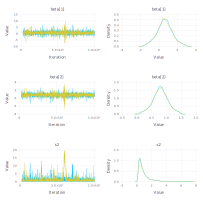

In [42]:
draw(p)

The plot function can also be used to make autocorrelation and running means plots. Legends can be added with the optional legend argument. Arrays of plots can be created and passed to the draw function. Use nrow and ncol to determine how many rows and columns of plots to include in each drawing.

In [44]:
## Autocorrelation and running mean plots
p = plot(sim1, [:autocor, :mean], legend=true)
draw(p, nrow=3, ncol=2, filename="autocormeanplot.svg")

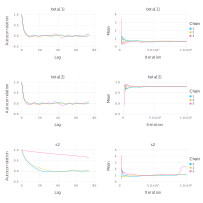

In [46]:
draw(p)

In [47]:
## Pairwise contour plots
p = plot(sim1, :contour)
draw(p, nrow=2, ncol=2, filename="contourplot.svg")

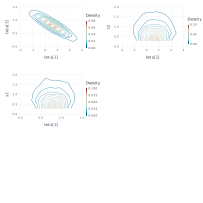

In [48]:
draw(p)

In [50]:
:c => [1, 2]

:c=>[1,2]

In [51]:
Dict{}

Dict{K,V}

In [35]:
collect(range(1, 2, 10))

10-element Array{Int64,1}:
  1
  3
  5
  7
  9
 11
 13
 15
 17
 19

In [36]:
collect(1:2:10)

5-element Array{Int64,1}:
 1
 3
 5
 7
 9

In [38]:
a = [1 for i in 1:10]

10-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1